In [8]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

In [2]:
# Load annotations.csv
annotations_path = 'generated_dataset/annotations.csv'
df = pd.read_csv(annotations_path)

# Define image size
img_size = (40, 40)

# Initialize empty arrays to store images and labels
images = []
labels = []

# Load images and labels from the dataset
for index, row in df.iterrows():
    img_path = os.path.join('generated_dataset', row['Image_Name'])
    label = row['Label']

    # Skip invalid labels
    if not label:
        continue

    # Read and resize the image
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, img_size)

    # Append image and label to the lists
    images.append(img)
    labels.append(label)

print("Image totals : ",len(images))

# Convert lists to numpy arrays
images = np.array(images)
labels = np.array(labels)


Image totals :  50000


In [3]:
# Normalize pixel values to be between 0 and 1
images = images / 255.0

# Convert labels to one-hot encoding
label_dict = {label: i for i, label in enumerate(np.unique(labels))}
num_classes = len(label_dict)
labels = np.array([label_dict[label] for label in labels])
labels = to_categorical(labels, num_classes=num_classes)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.3, random_state=42)

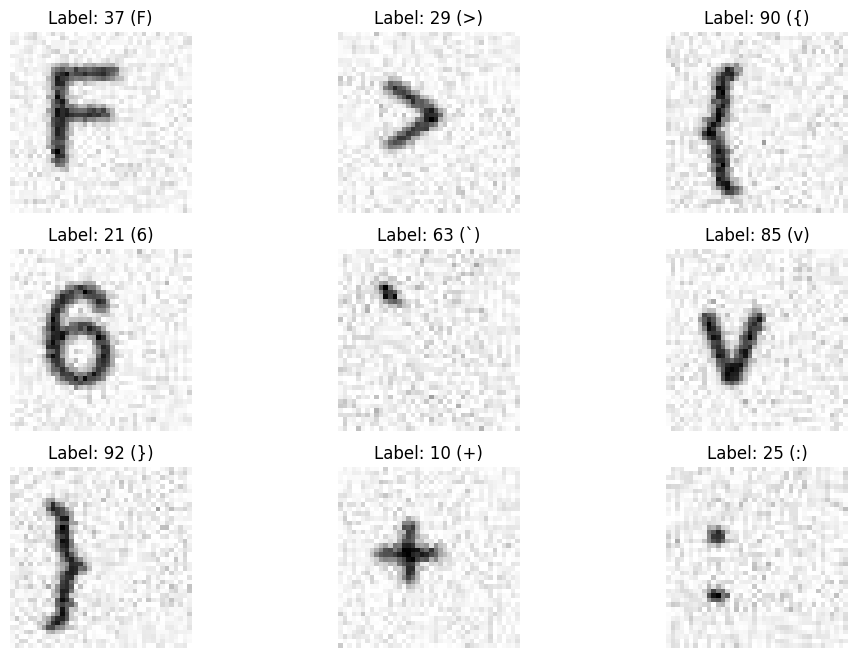

In [4]:
# Display 9 randomly selected training images with annotations
plt.figure(figsize=(12, 8))
random_indices = random.sample(range(len(X_train)), 9)

for i, idx in enumerate(random_indices):
    plt.subplot(3, 3, i + 1)
    plt.imshow(X_train[idx].reshape(40, 40), cmap='gray')
    plt.title(f"Label: {np.argmax(y_train[idx])} ({list(label_dict.keys())[list(label_dict.values()).index(np.argmax(y_train[idx]))]})")
    plt.axis('off')

plt.show()

In [9]:
# Build the CNN model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(40, 40, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 38, 38, 32)        320       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 19, 19, 32)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 11552)             0         
                                                                 
 dense_2 (Dense)             (None, 64)                739392    
                                                                 
 dense_3 (Dense)             (None, 94)                6110      
                                                                 
Total params: 745822 (2.85 MB)
Trainable params: 745822 (2.85 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

In [10]:
# Train the model
model.fit(X_train.reshape(-1, 40, 40, 1), y_train, epochs=20, validation_data=(X_test.reshape(-1, 40, 40, 1), y_test))

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test.reshape(-1, 40, 40, 1), y_test)
print(f'Test accuracy: {test_acc}')

# Save the model
model.save('image_classification_model.h5')

Epoch 1/20
1094/1094 [==============================] - 43s 38ms/step - loss: 1.6953 - accuracy: 0.6245 - val_loss: 0.1726 - val_accuracy: 0.9881
Epoch 2/20
1094/1094 [==============================] - 45s 41ms/step - loss: 0.0641 - accuracy: 0.9975 - val_loss: 0.0225 - val_accuracy: 1.0000
Epoch 3/20
1094/1094 [==============================] - 56s 51ms/step - loss: 0.0120 - accuracy: 1.0000 - val_loss: 0.0063 - val_accuracy: 1.0000
Epoch 4/20
1094/1094 [==============================] - 71s 65ms/step - loss: 0.0102 - accuracy: 0.9984 - val_loss: 0.0025 - val_accuracy: 1.0000
Epoch 5/20
1094/1094 [==============================] - 54s 49ms/step - loss: 0.0042 - accuracy: 0.9993 - val_loss: 0.0015 - val_accuracy: 1.0000
Epoch 6/20
1094/1094 [==============================] - 57s 52ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 8.1696e-04 - val_accuracy: 1.0000
Epoch 7/20
1094/1094 [==============================] - 52s 48ms/step - loss: 6.5738e-04 - accuracy: 1.0000 - val_loss: 

C:\Users\Ridwan Hidayatullah\AppData\Roaming\Python\Python39\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [11]:

# Load the trained model
model = load_model('image_classification_model.h5')
annotations_path = 'generated_dataset/annotations.csv'
df_annotations = pd.read_csv(annotations_path)

# Function to preprocess the input image for inference
def preprocess_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (40, 40))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    return img

# Function to predict the label of an image
def predict_image_label(image_path):
    img = preprocess_image(image_path)
    prediction = model.predict(img)
    predicted_label = np.argmax(prediction)
    confidence = prediction[0][predicted_label]
    return predicted_label, confidence

# Map predicted label to characters
characters = "!\"#$%&'()*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\]^_`abcdefghijklmnopqrstuvwxyz{|}~"
label_to_char = {i: char for i, char in enumerate(characters)}

# Predict labels for 10 random images
random_indices = random.sample(range(len(df_annotations)), 10)
for idx in random_indices:
    image_name = df_annotations.iloc[idx]["Image_Name"]
    image_path = os.path.join('generated_dataset', image_name)

    true_label = df_annotations.iloc[idx]["Label"]

    predicted_label, confidence = predict_image_label(image_path)
    predicted_character = label_to_char[predicted_label]

    print(f'Image: {image_path}')
    print(f'Ground Truth Label: {true_label}')
    print(f'Predicted Label: {predicted_character}, Confidence: {confidence:.2f}\n')

1/1 [==============================] - 0s 112ms/step
Image: generated_dataset\028679.jpg
Ground Truth Label: 2
Predicted Label: 2, Confidence: 1.00

1/1 [==============================] - 0s 27ms/step
Image: generated_dataset\016227.jpg
Ground Truth Label: 1
Predicted Label: 1, Confidence: 1.00

1/1 [==============================] - 0s 26ms/step
Image: generated_dataset\025685.jpg
Ground Truth Label: "
Predicted Label: ", Confidence: 1.00

1/1 [==============================] - 0s 31ms/step
Image: generated_dataset\030093.jpg
Ground Truth Label: k
Predicted Label: k, Confidence: 1.00

1/1 [==============================] - 0s 29ms/step
Image: generated_dataset\044116.jpg
Ground Truth Label: M
Predicted Label: M, Confidence: 1.00

1/1 [==============================] - 0s 32ms/step
Image: generated_dataset\032847.jpg
Ground Truth Label: F
Predicted Label: F, Confidence: 1.00

1/1 [==============================] - 0s 43ms/step
Image: generated_dataset\018666.jpg
Ground Truth Label: d
P